In [197]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (5,3) 
from utilities.preprocessing import airpls_baseline,butterworth_filter,peak_normalization,als_baseline
from scipy.signal import find_peaks

def crop_image(img):
    try:
        org_x,org_y,_ = img.shape
    except:
        org_x,org_y =img.shape
    l = []
    for i in range(0,2):
        jk = img.sum(axis=i)[:,0] - als_baseline(img.sum(axis=i)[:,0])
        jk =  butterworth_filter(peak_normalization(np.where(jk>0,jk,0)))
        peaks =  find_peaks(jk,prominence=0.2)[0]
        x,y = peaks[0]-400,peaks[-1]+400
        if x<0 or x > org_x: x = peaks[0]
        if y<0 or y> org_y: y=peaks[-1]
        l.append((x,y))
    return img[l[1][0]:l[1][1],l[0][0]:l[0][1]]

def get_count(image1,plot=True):
    image = image1.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 135, 255, cv2.THRESH_BINARY)
    #plt.imshow(gray, cmap='gray')
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    #plt.imshow(blur, cmap='gray')
    canny = cv2.Canny(blur, 30, 40, 3)
    #plt.imshow(canny, cmap='gray')
    dilated = cv2.dilate(canny, (1, 1), iterations=0) 
    #plt.imshow(dilated, cmap='gray')
    (cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    count = 0
    areas = []
    cntd = []
    for cn  in cnt:
        area = cv2.contourArea(cn)
        areas.append(area)
        if area>80:
            count+=1
            cntd.append(cn)

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.drawContours(rgb, cntd, -1, (0, 255, 0), 2)
   
    return count,areas

def get_blue(imageFrame1,plot=True):
    #imageFrame = cv2.subtract(imgy,dark)
    imageFrame = imageFrame1.copy()
    hsvFrame = cv2.cvtColor(imageFrame, cv2.COLOR_BGR2HSV)

    # Set range for blue color and
    # define mask
    blue_lower = np.array([94, 80, 2], np.uint8)
    blue_upper = np.array([120, 255, 255], np.uint8)
    blue_mask = cv2.inRange(hsvFrame, blue_lower, blue_upper)

    kernal = np.ones((2, 2), "uint8")

        # For blue color
    blue_mask = cv2.dilate(blue_mask, kernal)
    res_blue = cv2.bitwise_and(imageFrame, imageFrame,
                                   mask = blue_mask)

        # Creating contour to track blue color
    contours, hierarchy = cv2.findContours(blue_mask,
                                               cv2.RETR_TREE,
                                               cv2.CHAIN_APPROX_SIMPLE)
    b=0
    for pic, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            #print(area)
            if(area > 2000):
                x, y, w, h = cv2.boundingRect(contour)
                b+=1
                
    return b            

def white_count(img):
    lower_white = np.array([0,0,180])
    higher_white = np.array([255,255,255])
    white_range = cv2.inRange(img, lower_white, higher_white)
    (cnt, hierarchy) = cv2.findContours(white_range, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    kl = []
    for a in cnt:
        pr = cv2.contourArea(a)
        if pr>15: kl.append(pr)
    #qp=np.quantile(kl,0.9)
    count = len(kl)#len([i for i in kl if qp<i])
    return count
    
def white_count_2(img):
    lower_white = np.array([0,0,180])
    higher_white = np.array([255,255,255])
    white_range = cv2.inRange(img, lower_white, higher_white)
    (cnt, hierarchy) = cv2.findContours(white_range, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    kl = []
    for a in cnt:
        pr = cv2.contourArea(a)
        if pr>15: kl.append(pr)
    qp=np.quantile(kl,0.9)
    count = len([i for i in kl if qp<i])
    return count



def get_blue_1(imageFrame):
    #imageFrame = cv2.subtract(imgy,dark)
    hsvFrame = cv2.cvtColor(imageFrame, cv2.COLOR_BGR2HSV)



    # Set range for blue color and
    # define mask
    blue_lower = np.array([0, 51, 2], np.uint8)
    blue_upper = np.array([120, 255, 255], np.uint8)
    blue_mask = cv2.inRange(hsvFrame, blue_lower, blue_upper)

    kernal = np.ones((2, 2), "uint8")

        # For blue color
    blue_mask = cv2.dilate(blue_mask, kernal)
    res_blue = cv2.bitwise_and(imageFrame, imageFrame,
                                   mask = blue_mask)



        # Creating contour to track blue color
    contours, hierarchy = cv2.findContours(blue_mask,
                                               cv2.RETR_TREE,
                                               cv2.CHAIN_APPROX_SIMPLE)
    b=0
    jk = []
    for pic, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            #print(area)
            if(area > 0):
                x, y, w, h = cv2.boundingRect(contour)
                jk.append(area)
                imageFrame = cv2.rectangle(imageFrame, (x, y),
                                           (x + w, y + h),
                                           (255, 0, 0), 2)

               
    res = find_peaks(jk,prominence=max(jk)*0.25)[0].shape[0]
    return res   

def new_white_count(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (31,31), 0)
    canny = cv2.Canny(blur, 10, 50, 20)
    dilated = cv2.dilate(canny, (21, 21), iterations=1)
    (cnt, hierarchy) = cv2.findContours(
        dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ckl = []
    for i in cnt:
        a = cv2.contourArea(i)
        if a>5: ckl.append(a)
    return find_peaks(ckl)[0].shape

def get_analysis(path):
    blue, white,tol_count,white_2,white_3=0,0,0,0,0
    blue1,white1=0,0
    try: img = cv2.imread(path)
    except Exception as e:
        print(e)
        img = path
        #return {"blue":blue,"white":white,"Total":tol_count}
    try:
        img_p = img#crop_image(img)
    except Exception as e:
        print(e)
    try:
        blue = get_blue(img_p)
        blue1 = get_blue_1(img_p)
    except Exception as e:
        print(e,"BLUE")
    try:
        white = white_count(img_p)
        white1,_ = get_count(img_p)
        white_2 = white_count_2(img_p)
        white_3 = new_white_count(img_p)[0]
    except Exception as e:
        print(e,"WHITE")
    tol_count=blue+white
    return {"blue":blue,"blue1":blue1,"white":white,"Total":tol_count,"white1":white1,"white2":white_2,"white3":white_3,"img_shape":img.shape,"Image_Mean":img.mean()} 

In [2]:
def plot_image(img,size=(10,10)):
    rows = len(img) if len(img)%2==0 else len(img)+1
    
    fig, ax = plt.subplots(ncols=2,nrows=rows,figsize=size)
    
    r = 0
    for i,j in enumerate(img):

        if rows==1:
            ax[i%2].imshow(j)
            #ax[i%2].axis('off')
        else:
            ax[r,i%2].imshow(j)
            #ax[r,i%2].axis('off')
        if (i%2)==1: r+=1
        
    
    #plt.show()
            

In [3]:
img = cv2.imread('./Rice_dataset/20220917_002446.jpg')
img.shape

(4080, 3060, 3)

In [4]:

from skimage.filters import threshold_multiotsu

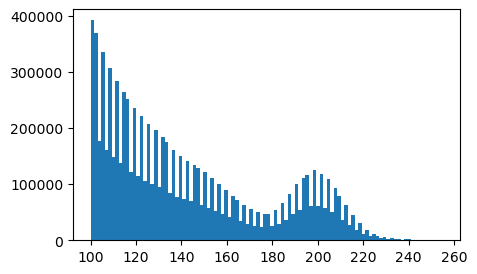

In [5]:
plt.hist(img.flatten(), bins=100, range=(100,255))
plt.show()

# Region based image

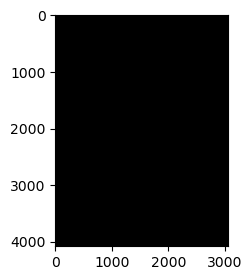

In [6]:
region1 = (img >= 0) & (img <75)
region2 = (img >= 75) & (img <140)
region3 = (img >= 140) & (img <200)
region4 = (img >= 200) & (img <=255)
all_regions = np.zeros(img.shape) #Create 3 channel blank image of same size as original
#all_regions[region1] = (1,0,0)
#all_regions[region2] = (0,1,0)
#all_regions[region3] = (0,0,1)
#all_regions[region4] = (1,1,0)
plt.imshow(all_regions)

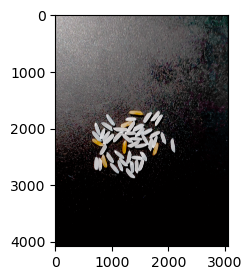

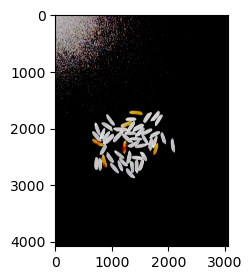

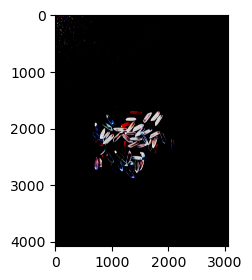

In [7]:
all_regions = np.where((img >= 0) & (img <75),(1,0,0),img)
plt.imshow(all_regions)
plt.show()
all_regions = np.where((img >= 75) & (img <140),(0,1,0),all_regions)
plt.imshow(all_regions)
plt.show()
all_regions = np.where((img >= 140) & (img <200),(0,0,1),all_regions)
plt.imshow(all_regions)
plt.show()



C:\Users\admin\AppData\Local\Temp\ipykernel_16092\463881372.py:1: UserWarning: threshold_multiotsu is expected to work correctly only for grayscale images; image shape (4080, 3060, 3) looks like that of an RGB image.
  thresholds = threshold_multiotsu(img, classes=3)


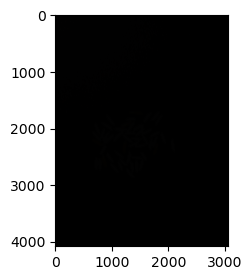

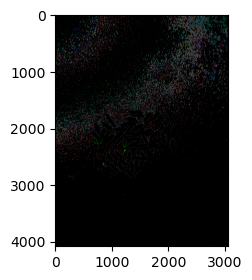

In [15]:
thresholds = threshold_multiotsu(img, classes=3)
regions = np.digitize(img, bins=thresholds)
plt.imshow(regions)
plt.show()

segm1 = (regions == 0)
segm2 = (regions == 1)
segm3 = (regions == 2)


from scipy import ndimage as nd

#segm1_opened = nd.binary_opening(segm1, np.ones((3,3)))
#segm1_closed = nd.binary_closing(segm1_opened, np.ones((3,3)))

segm1_opened = nd.binary_opening(np.where(segm1==True,1,0), np.ones((3,3,1)))
segm1_closed = nd.binary_closing(segm1_opened, np.ones((3,3,1)))

segm2_opened = nd.binary_opening(np.where(segm2==True,1,0), np.ones((3,3,1)))
segm2_closed = nd.binary_closing(segm2_opened, np.ones((3,3,1)))

segm3_opened = nd.binary_opening(np.where(segm3==True,1,0), np.ones((3,3,1)))
segm3_closed = nd.binary_closing(segm3_opened, np.ones((3,3,1)))

#segm4_opened = nd.binary_opening(np.where(segm4==True,1,0), np.ones((3,3,1)))
#segm4_closed = nd.binary_closing(segm4_opened, np.ones((3,3,1)))
all_segments_cleaned = np.zeros((img.shape[0], img.shape[1], 3)) 
all_segments_cleaned =  np.where(segm1_closed==True,(1,0,0),img)
all_segments_cleaned =  np.where(segm2_closed==True,(0,1,0),all_segments_cleaned)
all_segments_cleaned =  np.where(segm3_closed==True,(0,0,1),all_segments_cleaned)
#all_segments_cleaned =  np.where(segm4_closed==True,(1,1,0),all_segments_cleaned)
plt.imshow(all_segments_cleaned)
#all_segments_cleaned = np.zeros((img.shape[0], img.shape[1], 3)) 

#all_segments_cleaned = np.where(img)


# Denoising

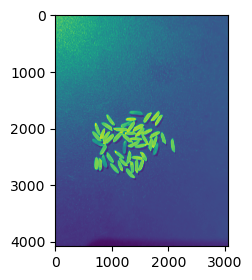

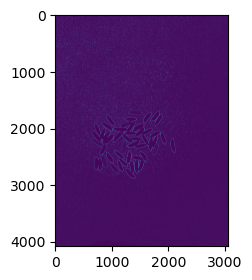

In [120]:
from skimage import io
from skimage.filters import gaussian, sobel



gaussian_using_skimage = gaussian(img, sigma=1, mode='constant', cval=0.0)
plt.imshow(gaussian_using_skimage)
plt.show()
#img_gray = io.imread("images/Osteosarcoma_01.tif", as_gray=True)
sobel_img = sobel(img)  #Works only on 2D (gray) images
plt.imshow(sobel_img)

In [ ]:
gaussian_using_cv2 = cv2.GaussianBlur(img, (3,3), 0, borderType=cv2.BORDER_CONSTANT)

gaussian_using_skimage = gaussian(img, sigma=1, mode='constant', cval=0.0)

In [ ]:
plot_image([gaussian_using_cv2,gaussian_using_skimage])

In [ ]:
from skimage.transform import resize,resize_local_mean
img = resize_local_mean(img,(512,512))

In [ ]:
import cv2
import numpy as np
from skimage import io, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma

In [ ]:
sigma_est = np.mean(estimate_sigma(img, multichannel=True))
#sigma_est = 0.1

denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True,
                               patch_size=5, patch_distance=3, multichannel=True)

In [ ]:
plt.imshow(denoise_img)

In [ ]:
plt.hist(denoise_img.flatten(),bins=150,range=(0,255))
plt.show()

In [ ]:
from skimage.restoration import denoise_tv_chambolle

In [ ]:
denoise_img = denoise_tv_chambolle(img, weight=0.1, eps=0.0002, n_iter_max=200, multichannel=False)

In [ ]:
plt.hist(denoise_img.flatten(),bins=100,range=(0,1))
plt.show()

In [ ]:
import bm3d
BM3D_denoised_image = bm3d.bm3d(img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
plt.imshow(BM3D_denoised_image)

In [ ]:
plt.hist(BM3D_denoised_image.flatten(),bins=100,range=(0,1))
plt.show()

In [ ]:
plot_image([img[:,:,0],img[:,:,1]])

# Edge detection

In [ ]:
from skimage import io, filters, feature
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import cv2
import numpy as np

from skimage.filters import roberts, sobel, scharr, prewitt, farid

roberts_img = roberts(img[:,:,0])
sobel_img = sobel(img[:,:,0])
scharr_img = scharr(img[:,:,0])
prewitt_img = prewitt(img[:,:,0])
farid_img = farid(img[:,:,0])

for i in [roberts_img,sobel_img,scharr_img,prewitt_img,farid_img]:
    plt.imshow(i)
    plt.show()

In [ ]:
plt.rcParams['figure.figsize']=(20,4)

# FFT on Image

In [ ]:
x = np.arange(256)  # generate values from 0 to 255 (our image size)
y = np.sin(2 * np.pi * x / 3)  #calculate sine of x values
#Divide by a smaller number above to increase the frequency.
y += max(y) # offset sine wave by the max value to go out of negative range of sine 

#Generate a 256x256 image (2D array of the sine wave)
img_2 = np.array([[y[j]*127 for j in range(256)] for i in range(256)], dtype=np.uint8) # create 2-D array of sine-wave
plt.imshow(img_2)

In [ ]:

dft = cv2.dft(np.float32(img_2), flags=cv2.DFT_COMPLEX_OUTPUT)

dft_shift = np.fft.fftshift(dft)


magnitude_spectrum = 120 * np.log((cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))+1)


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_2)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum)
ax2.title.set_text('FFT of image')
plt.show()

In [ ]:
pk = 0.002
#For fft in opencv input image needs to be converted to float32
dft = cv2.dft(np.float32(img[:,:,0]), flags=cv2.DFT_COMPLEX_OUTPUT)

#Rearranges a Fourier transform X by shifting the zero-frequency 
#component to the center of the array.
#Otherwise it starts at the tope left corenr of the image (array)
dft_shift = np.fft.fftshift(dft)

##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = pk * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))


# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

rows, cols = img[:,:,0].shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0


# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = pk * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
#img_back = sobel(img_back)


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()


# histogram equalization

In [ ]:
img = cv2.imread('./Rice_Set/4.jpg')
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)

ev = cv2.equalizeHist(l)

up_img = cv2.merge((ev,a,b))

up_img = cv2.cvtColor(up_img,cv2.COLOR_LAB2BGR)
plt.hist(up_img.flatten(),bins=100,range=(0,255))
plt.show()

In [ ]:
plt.imshow(up_img)
get_analysis(up_img)

In [ ]:
plt.imshow(np.float64(BM3D_denoised_image))

In [ ]:
img = cv2.imread('./Rice_Set/6.jpg')
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)
clahe=  cv2.createCLAHE(3.0,(8,8))
clahe_img = clahe.apply(l)
up_img_2 = cv2.merge((clahe_img,a,b))
up_img = cv2.cvtColor(up_img_2,cv2.COLOR_LAB2BGR)
plt.hist(up_img_2.flatten(),bins=100,range=(0,255))
plt.show()

In [ ]:
plt.imshow(up_img_2)
get_analysis(up_img_2)

In [119]:
def plot_compare(img):
    fig,ax = plt.subplots(ncols=len(img),nrows=1)
    for i,image in enumerate(img):
        ax[i%2].imshow(image)
    plt.show()
    

In [ ]:
img = cv2.imread('./Rice_Set/6.jpg',0)
plt.imshow(img)
img.shape

#  Shading correction using rolling ball

In [ ]:
from cv2_rolling_ball import subtract_background_rolling_ball
radius=50
final_img, background = subtract_background_rolling_ball(img[:,:,0], radius, light_background=True,
                                     use_paraboloid=True, do_presmooth=True)


#optionally perform CLAHE to equalize histogram for better segmentation
#otherwise the image may appear washedout. 



In [ ]:
clahe = cv2.createCLAHE(3.0,(8,8))
c_img = clahe.apply(final_img)


In [ ]:
plot_compare([final_img,c_img])

In [ ]:
plt.hist(final_img.flatten(),bins=100,range=(0,255))
plt.show()

In [ ]:
subImg_1 = cv2.subtract(final_img,background)
plt.imshow(subImg_1)

In [ ]:
plt.hist(subImg_1.flatten(),bins=100,range=(0,255))
plt.show()

In [ ]:
subImg_1 = cv2.subtract(c_img,background)
plt.imshow(subImg_1)
plt.show()
plt.hist(subImg_1.flatten(),bins=100,range=(0,255))
plt.show()

## types of colors
* HSV: Hue saturation and value
* LAB: Lightness a - > green to red b -> blue to green

# applying  filter

In [ ]:
from skimage import filters
from skimage.color.adapt_rgb import adapt_rgb,each_channel,hsv_value
@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


In [ ]:
img = cv2.imread('./Rice_dataset/20220917_002458.jpg')
plot_compare([img,sobel_each((img))])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print(f'Known offset (y, x): {shift}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')

In [ ]:
ref_img = np.random.randint(30,255,img.shape)

#  Measure with reference

In [ ]:
from sewar import full_ref
from skimage import measure, metrics

In [ ]:
mse_sk = metrics.mean_squared_error(img,ref_img)
mse_sk

In [ ]:
peaks_snr = metrics.peak_signal_noise_ratio(img,img)
peaks_snr

In [ ]:
full_ref.ergas(ref_img,img,r=4,ws=8)

In [ ]:
full_ref.ssim(img,ref_img)

In [ ]:
full_ref.uqi(ref_img,img)

# measure quality without references

In [ ]:
import imquality.brisque as brisque
from skimage import io, img_as_float

# Thresholding 

In [16]:
img = cv2.imread('./Rice_dataset/20220917_002458.jpg')

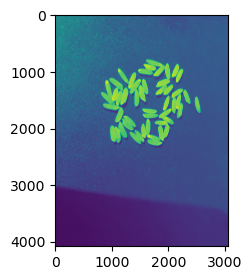

In [17]:
bc = img[:,:,0]
plt.imshow(bc)

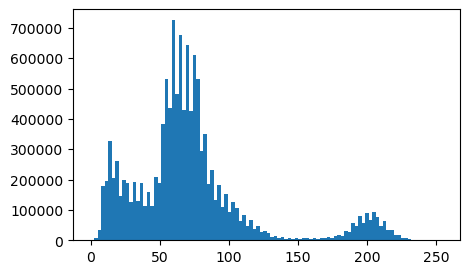

In [18]:
plt.hist(bc.flatten(),bins=100,range=(0,255))
plt.show()

# Manual

In [19]:
back = bc<=160
nuc =  bc > 160

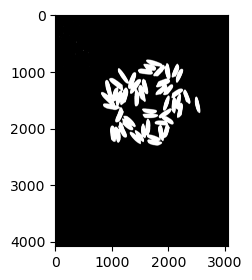

In [20]:
plt.imshow(nuc,cmap='gray')

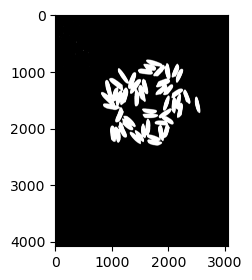

In [21]:
res1,th1 =  cv2.threshold(bc,160,255,cv2.THRESH_BINARY)
plt.imshow(th1,cmap='gray')

# Automatic

In [22]:
res2, thr2 = cv2.threshold(bc,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

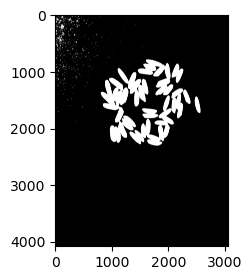

In [23]:
plt.imshow(thr2,'gray')

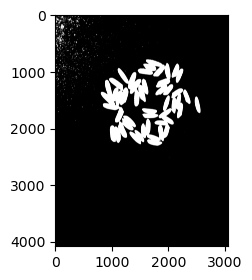

In [24]:
reg3 =  np.digitize(bc,bins=np.array([res2]))
plt.imshow(reg3,'gray')

# Multi region automatic

* opening = > erosion and dilation
* closing -> dilation and erosion
* skelation -> erode untill single pixel

In [63]:
from skimage.filters import threshold_multiotsu,threshold_otsu

In [28]:
thresholds =  threshold_multiotsu(img,classes=2)

C:\Users\admin\AppData\Local\Temp\ipykernel_16092\2501293373.py:1: UserWarning: threshold_multiotsu is expected to work correctly only for grayscale images; image shape (4080, 3060, 3) looks like that of an RGB image.
  thresholds =  threshold_multiotsu(img,classes=2)


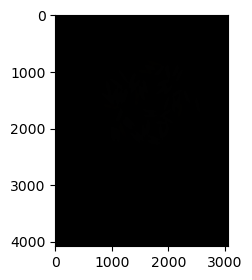

In [30]:
res = np.digitize(img,bins=thresholds)
plt.imshow(res,'PuBu')

# Advance Texture finding

### gabor conv kernal

In [3]:
def show(img):
    plt.imshow(img)
    plt.show()

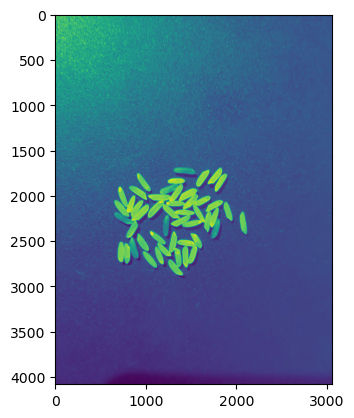

In [4]:
from scipy import ndimage
from skimage import io
img = io.imread("./Rice_dataset/20220917_002446.jpg",as_gray=True)
k = 7
img_mean = ndimage.uniform_filter(img,(k,k))
show(img_mean)

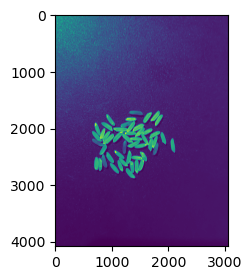

In [50]:
img_sq_mean = ndimage.uniform_filter(img**2,(k,k))
show(img_sq_mean)

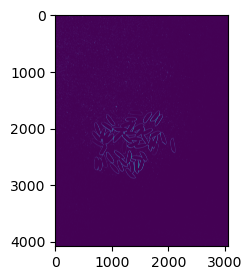

In [51]:
img_var = img_sq_mean -img_mean**2
show(img_var)

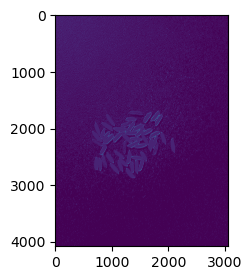

In [56]:
ksize = 45
theta = np.pi/3
kernel = cv2.getGaborKernel((ksize,ksize),5.0,theta,10,0.9,0,ktype=cv2.CV_32F)
filter_img = cv2.filter2D(img,cv2.CV_8UC3,kernel)
show(filter_img)

# Entropy for texture detection

C:\Users\admin\AppData\Local\Temp\ipykernel_16092\2548751636.py:3: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entory_img = entropy(img,disk(3))


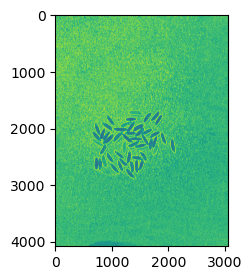

In [85]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
entory_img = entropy(img,disk(3))
show(entory_img)

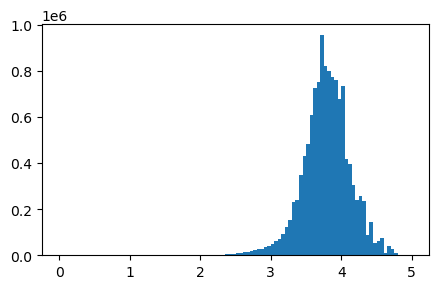

In [86]:
plt.hist(entory_img.flatten(),bins=100,range=(0,5))
plt.show()

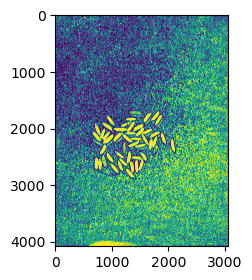

In [87]:
thresh = threshold_otsu(entory_img)
binary_img = entory_img <= thresh
show(binary_img)

In [88]:
stn =  np.sum(binary_img==1)
stn

5977752

In [89]:
scale = 0.45
stn*((scale)**2)

1210494.78

# Scrath Array analysis

using reg and find stn**((scale)**2) for time line image

# Image to segmentation to objects to properties

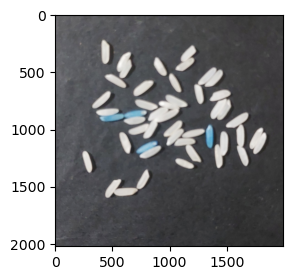

In [347]:
img = io.imread("./Rice_Set/4.jpg",)
show(img)

img_1 = np.float32(sobel(img[:,:,0]))
#get_analysis(img)


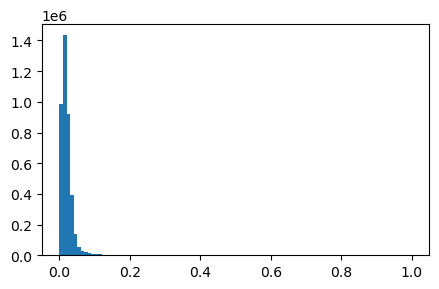

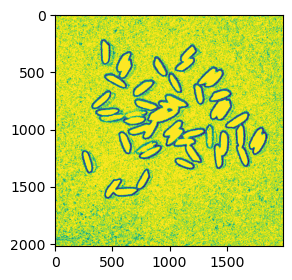

In [348]:
from skimage.filters import threshold_otsu
scale =  0.6
plt.hist(img_1.flatten(),bins=100,range=(0,1))
plt.show()
threshold = threshold_otsu(img_1)
threshold_img = img_1<=threshold
show(threshold_img)

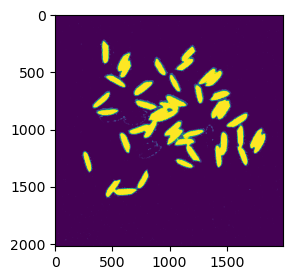

In [349]:
from skimage.segmentation import clear_border
edge_touching_removed = clear_border(threshold_img)
show(edge_touching_removed)

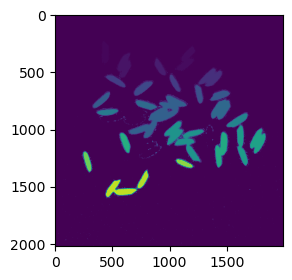

In [350]:
from skimage import measure
from skimage.color import lab2rgb, rgb2gray,label2rgb
label_image = measure.label(edge_touching_removed,connectivity=img_1.ndim)
show(label_image)

In [351]:
thres = threshold_otsu(label_image)
thres =  label_image<=thres


In [352]:
img_label_overlay = label2rgb(label_image,image=img)

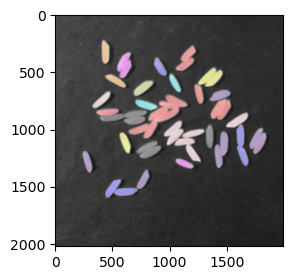

In [353]:
show(img_label_overlay)

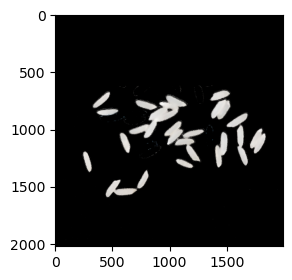

In [354]:
result = img.copy()
result[thres] = (0,0,0)
show(result)

In [355]:
get_analysis(result)

Can't convert object to 'str' for 'filename'


{'blue': 0,
 'blue1': 13,
 'white': 94,
 'Total': 94,
 'white1': 8,
 'white2': 10,
 'white3': 57,
 'img_shape': (2021, 1992, 3),
 'Image_Mean': 14.260992593166662}

In [356]:
img.shape

(2021, 1992, 3)

In [357]:
props = measure.regionprops_table(label_image,img,properties=['label','area',
                                                             'equivalent_diameter',
                                                             'mean_intensity','solidity'])

In [358]:
import pandas as pd
df = pd.DataFrame(props)
df

,label,area,equivalent_diameter,mean_intensity-0,mean_intensity-1,mean_intensity-2,solidity
0,1,1,1.128379,112.0,113.0,117.0,1.0
1,2,1,1.128379,63.0,64.0,66.0,1.0
2,3,1,1.128379,75.0,75.0,75.0,1.0
3,4,1,1.128379,104.0,103.0,108.0,1.0
4,5,1,1.128379,84.0,84.0,84.0,1.0
...,...,...,...,...,...,...,...
3925,3926,1,1.128379,26.0,26.0,26.0,1.0
3926,3927,1,1.128379,60.0,60.0,62.0,1.0
3927,3928,1,1.128379,76.0,76.0,78.0,1.0
3928,3929,1,1.128379,48.0,49.0,51.0,1.0


In [359]:
df['area_sq_microns'] =  df['area']*(scale**2)

In [360]:
df['equivalent_diameter_microns'] = df['equivalent_diameter']*scale

In [361]:
df

,label,area,equivalent_diameter,mean_intensity-0,mean_intensity-1,mean_intensity-2,solidity,area_sq_microns,equivalent_diameter_microns
0,1,1,1.128379,112.0,113.0,117.0,1.0,0.36,0.677028
1,2,1,1.128379,63.0,64.0,66.0,1.0,0.36,0.677028
2,3,1,1.128379,75.0,75.0,75.0,1.0,0.36,0.677028
3,4,1,1.128379,104.0,103.0,108.0,1.0,0.36,0.677028
4,5,1,1.128379,84.0,84.0,84.0,1.0,0.36,0.677028
...,...,...,...,...,...,...,...,...,...
3925,3926,1,1.128379,26.0,26.0,26.0,1.0,0.36,0.677028
3926,3927,1,1.128379,60.0,60.0,62.0,1.0,0.36,0.677028
3927,3928,1,1.128379,76.0,76.0,78.0,1.0,0.36,0.677028
3928,3929,1,1.128379,48.0,49.0,51.0,1.0,0.36,0.677028


<AxesSubplot:ylabel='Density'>

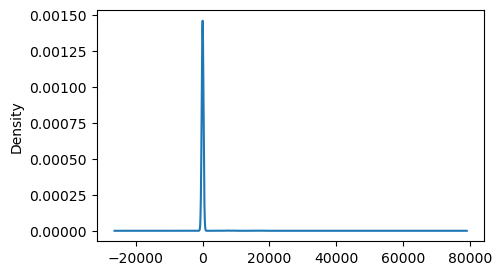

In [362]:
df['area'].plot(kind='kde')

# Blob Detection

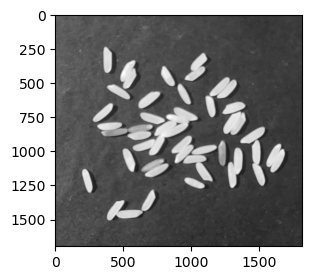

In [391]:
img = cv2.imread('./Rice_Set/5.jpg',0)
img1 = cv2.imread('./Rice_Set/5.jpg')
plt.imshow(img,cmap='gray')


In [377]:
params = cv2.SimpleBlobDetector_Params()

In [386]:
params.minThreshold=0
params.maxThreshold=255

params.filterByArea =True
params.minArea = 30
params.maxArea = 100000000

params.filterByColor = True
params.blobColor = 0


params.filterByCircularity = True
params.minCircularity = 0.1
params.maxCircularity = 1

params.filterByConvexity = True
params.minConvexity = 0.1
params.maxConvexity = 1

params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio =1


params.minDistBetweenBlobs = 0

detector = cv2.SimpleBlobDetector_create(params)

In [387]:
keypoints = detector.detect(img)

In [388]:
len(keypoints)

55

In [392]:
img_with_blob = cv2.drawKeypoints(img1,keypoints,np.array([]),(255,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

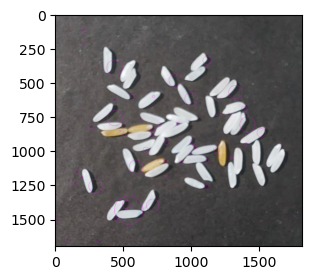

In [393]:
show(img_with_blob)

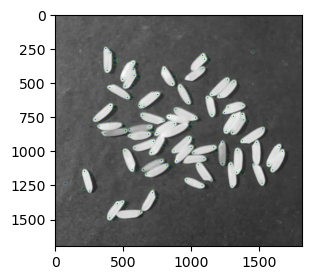

In [394]:

img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

#cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]])
#if dp=1 , the accumulator has the same resolution as the input image. 
#If dp=2 , the accumulator has half as big width and height.
#minDist – Minimum distance between the centers of the detected circles.
#minRadius – Minimum circle radius.
#maxRadius – Maximum circle radius.

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 30,
                            param1=50, param2=12, minRadius=10, maxRadius=20)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
show(cimg)

# Watershed

C:\Users\admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


55.725586
   label     area  equivalent_diameter  mean_intensity  solidity  orientation  \
0     10  2656948          1839.274656       78.293414  0.866512    -1.516091   
1     11     9919           112.379994      210.066035  0.957525     0.039890   
2     12     8077           101.409841      212.403120  0.948005    -0.788305   
3     13    16153           143.410733      214.199591  0.905184    -0.230000   
4     14     8224           102.328501      200.900900  0.925084    -1.007981   

      perimeter  
0  23870.457998  
1    478.948268  
2    436.801082  
3    660.718867  
4    448.694480  
   label     area  equivalent_diameter  mean_intensity  solidity  orientation  \
0     10  2656948          1839.274656       78.293414  0.866512    -1.516091   
1     11     9919           112.379994      210.066035  0.957525     0.039890   
2     12     8077           101.409841      212.403120  0.948005    -0.788305   
3     13    16153           143.410733      214.199591  0.905184    -0.

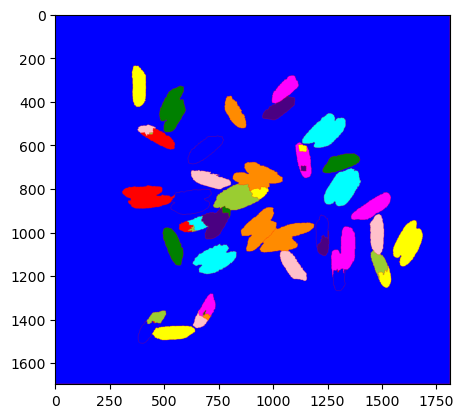

In [1]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io


img = cv2.imread("Rice_Set/5.jpg")
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.


pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
plt.imshow(opening, cmap='gray') #This is our image to be segmented further using watershed

#Check the total regions found before and after applying this. 

#STEP 1: Sude background 
#Now we know that the regions at the center of cells is for sure cells
#The region far away is background.
#We need to extract sure regions. For that erode a few times. 
#But we have cells touching, so erode alone will not work. 
#To separate touching objects, the best approach would be distance transform and then thresholding.

# let us start by identifying sure background area
# dilating pixes a few times increases cell boundary to background. 
# This way whatever is remaining for sure will be background. 
#The area in between sure background and foreground is our ambiguous area. 
#Watershed should find this area for us. 
sure_bg = cv2.dilate(opening,kernel,iterations=10)
plt.imshow(sure_bg, cmap='gray') #Dark region is our sure background

# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform, cmap='gray') #Dist transformed img. 


#Let us threshold the dist transform by starting at 1/2 its max value.
print(dist_transform.max()) #gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
plt.imshow(sure_fg, cmap='gray')

#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)  #Convert to uint8 from float
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap='gray')

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
#Connected components labeling scans an image and groups its pixels into components 
#based on pixel connectivity, i.e. all pixels in a connected component share 
#similar pixel intensity values and are in some way connected with each other. 
#Once all groups have been determined, each pixel is labeled with a graylevel 
# or a color (color labeling) according to the component it was assigned to.
ret3, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)

#Let us color boundaries in yellow. 
#Remember that watershed assigns boundaries a value of -1
img[markers == -1] = [0,255,255]  

#label2rgb - Return an RGB image where color-coded labels are painted over the image.
img2 = color.label2rgb(markers, bg_label=0)

plt.imshow(img2)


#####################################################################################
#Now, time to extract properties of detected cells
#Directly capturing props to pandas dataframe
    
props = measure.regionprops_table(markers, cells, 
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity', 'orientation',
                                      'perimeter'])

import pandas as pd
df = pd.DataFrame(props)
print(df.head())

#To delete small regions...
df = df[df['area'] > 50]
print(df.head())

#######################################################
#Convert to micron scale
df['area_sq_microns'] = df['area'] * (pixels_to_um**2)
df['equivalent_diameter_microns'] = df['equivalent_diameter'] * (pixels_to_um)
print(df.head())

# Object detection by template matching

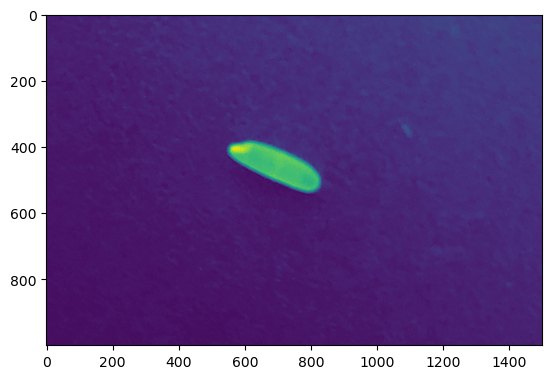

In [13]:
template = cv2.imread('./data/images/20220918_001632.jpg',0)[2000:3000,500:2000]
show(template)
img = cv2.imread('./Rice_Set/3.jpg',0)

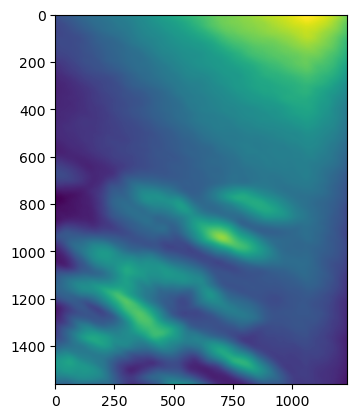

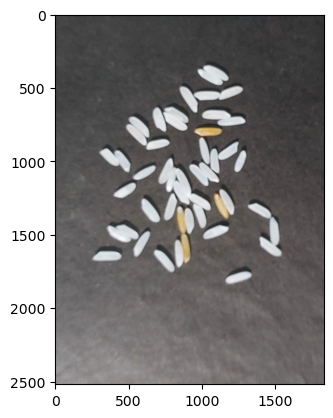

In [19]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

img_rgb = cv2.imread('./Rice_Set/3.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('./data/images/20220918_001632.jpg',0)#[2000:3000,500:2000]
#template = cv2.imread('./Rice_Set/3.jpg',0)
h, w = template.shape[::]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
show(res)

threshold = 0.8 #Pick only values above 0.8. For TM_CCOEFF_NORMED, larger values = good fit.

loc = np.where( res >= threshold)  
#Outputs 2 arrays. Combine these arrays to get x,y coordinates - take x from one array and y from the other.

#Reminder: ZIP function is an iterator of tuples where first item in each iterator is paired together,
#then the second item and then third, etc. 

for pt in zip(*loc[::-1]):   #-1 to swap the values as we assign x and y coordinate to draw the rectangle. 
    #Draw rectangle around each object. We know the top left (pt), draw rectangle to match the size of the template image.
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 1)  #Red rectangles with thickness 2. 

#cv2.imwrite('images/template_matched.jpg', img_rgb)
show(img_rgb)

# Cluster using Kmeans for image

In [213]:
img = cv2.imread('./Rice_Set/7.jpg')
#img = sobel(img)

In [214]:
img_2 = img.reshape((-1,3))

In [215]:
img.shape,img_2.shape

((1674, 2669, 3), (4467906, 3))

In [216]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10)

log = LogisticRegression()

In [217]:
model = kmeans.fit(img_2)


In [218]:
pred = kmeans.predict(img_2)


In [219]:
pred.shape

(4467906,)

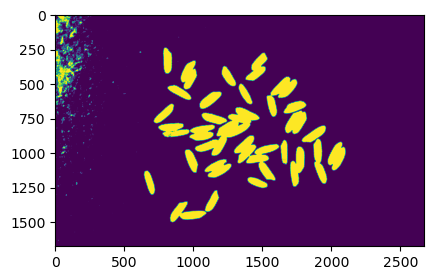

In [220]:
pred = pred.reshape((img.shape[0],img.shape[1]))
show(pred)

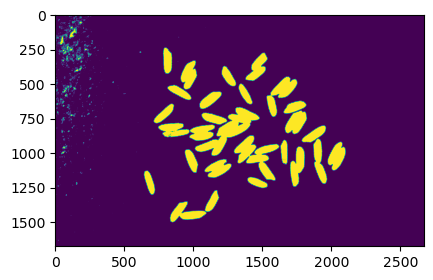

In [221]:
from skimage.segmentation import clear_border
from skimage import io
from skimage.filters import gaussian, sobel
edge_touching_removed = clear_border(pred)
#plot_compare([img,edge_touching_removed])
show(edge_touching_removed)

In [222]:
mask =  np.where(edge_touching_removed>0,True,False)

In [223]:
mask =  np.where(edge_touching_removed>0,True,False)
res = cv2.bitwise_and(np.uint8(img), np.uint8(img), mask=np.uint8(mask))

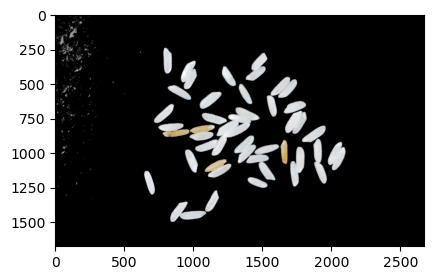

In [224]:
show(res)

In [225]:
get_analysis(res)

Can't convert object to 'str' for 'filename'


{'blue': 3,
 'blue1': 3,
 'white': 41,
 'Total': 44,
 'white1': 54,
 'white2': 4,
 'white3': 84,
 'img_shape': (1674, 2669, 3),
 'Image_Mean': 19.745242551357766}

# GMM

In [230]:
from sklearn.mixture import GaussianMixture as GMM

In [231]:
modelgmm =  GMM(n_components=2,covariance_type='tied').fit(img_2)

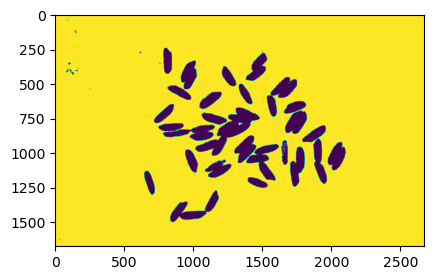

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [243]:
predgmm = modelgmm.predict(img_2)
pred = predgmm.reshape((img.shape[0],img.shape[1]))

show(pred)
pred

In [244]:
pred = np.where(pred==0,True,False)

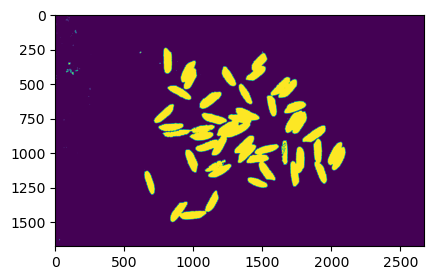

In [245]:
show(pred)

In [248]:
bic_value = modelgmm.bic(img_2) ## best number of compontnes and largest it is worst
bic_value

90461370.31809117

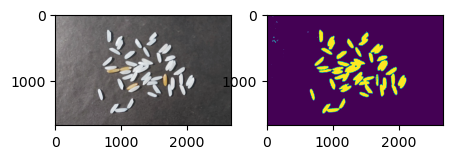

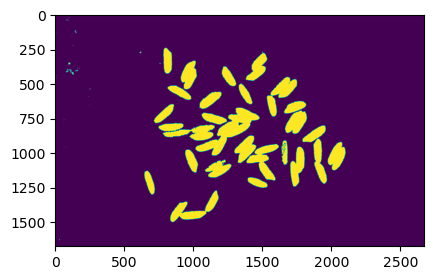

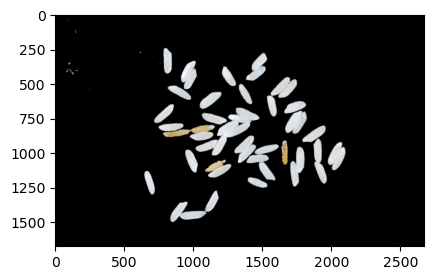

In [246]:
from skimage.segmentation import clear_border
from skimage import io
from skimage.filters import gaussian, sobel
edge_touching_removed = clear_border(pred)
plot_compare([img,edge_touching_removed])
show(edge_touching_removed)
mask =  np.where(edge_touching_removed==0,False,True)
res = cv2.bitwise_and(np.uint8(img), np.uint8(img), mask=np.uint8(mask))
show(res)

### BIC CAL 
* <h3>best number of compontnes and largest it is worst</h3>

In [ ]:

n_com =  np.arange(1,10,1)
gmm_mpdels = [GMM(n,covariance_type='tied').fit(img_2) for n in n_com]
plt.plot(n_com,[m.bic(img_2) for m in gmm_mpdels])

In [247]:
get_analysis(res)

Can't convert object to 'str' for 'filename'


{'blue': 3,
 'blue1': 3,
 'white': 41,
 'Total': 44,
 'white1': 49,
 'white2': 4,
 'white3': 65,
 'img_shape': (1674, 2669, 3),
 'Image_Mean': 18.881545404043862}